In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
# hyperparameters
window_size = 10
batch_size = 200
num_classes = 2
learning_rate = 0.1
state_size = 4
num_samples = 100000
num_training_epochs = 20

In [0]:
def generate_data():
  X = np.random.choice(a=[0,1], size=(num_samples))
  Y = []
  for index in range(num_samples):
    thresh = 0.5
    if X[index-3] == 1:
      thresh += 0.5
    if X[index-8] == 1:
      thresh -= 0.25
    if np.random.rand() > thresh:
      Y.append(0)
    else:
      Y.append(1)
  return X, np.array(Y)

In [0]:
def get_next_batch(epoch_size, index):
  return data_x[:,index*window_size:(index+1)*window_size], data_y[:,index*window_size:(index+1)*window_size]

In [0]:
def rnn_cell(rnn_input, state):
  with tf.variable_scope('rnn_cell', reuse=tf.AUTO_REUSE):
    weight = tf.get_variable(name='w', shape=[num_classes+state_size, state_size])
    bias = tf.get_variable(name='b', shape=[state_size], initializer=tf.constant_initializer(0.0))
  next_state = tf.tanh(tf.add(tf.matmul(tf.concat([rnn_input,state], 1), weight), bias))
  return next_state

In [0]:
def class_scores():
	with tf.variable_scope('softmax_predictions',reuse=tf.AUTO_REUSE):
	  weight = tf.get_variable(name='w', shape=[state_size,num_classes])
	  bias = tf.get_variable(name='b', shape=[num_classes], initializer=tf.constant_initializer(0.0))
	logits = [tf.add(tf.matmul(rnn_output, weight), bias) for rnn_output in rnn_outputs]
	return logits

In [0]:
raw_x, raw_y = generate_data()

batch_partition_length = num_samples//batch_size
data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)

for i in range(batch_size):
  data_x[i] = raw_x[batch_partition_length*i:batch_partition_length*(i+1)]
  data_y[i] = raw_y[batch_partition_length*i:batch_partition_length*(i+1)]

In [8]:
x = tf.placeholder(dtype=tf.int32, shape=[batch_size, window_size], name='input_placeholder')
y = tf.placeholder(dtype=tf.int32, shape=[batch_size, window_size], name='label_placeholder')
init_state = tf.zeros(shape=[batch_size, state_size], dtype=tf.float32)

x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unstack(x_one_hot, axis=1)

cell_state = init_state
rnn_outputs = []

for rnn_input in rnn_inputs:
  cell_state = rnn_cell(rnn_input, cell_state)
  rnn_outputs.append(cell_state)
final_cell_state = rnn_outputs[window_size-1]

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
logits = class_scores()
output_predictions = [tf.nn.softmax(logit) for logit in logits]

y_as_list = tf.unstack(y, num=window_size, axis=1)
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logit, labels=label) for logit,label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)

In [0]:
def train_network(num_epochs):
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    training_loss = []

    epoch_size = batch_partition_length//window_size
    
    for epoch in range(num_epochs):
      for index in range(epoch_size):
        [batch_x, batch_y] = get_next_batch(epoch_size, index)
        _, loss_val = sess.run([train_step, total_loss], feed_dict={x:batch_x, y:batch_y})
        training_loss.append(loss_val)
#         print("Epoch :", epoch, "iteration :", index, "Loss Value :", loss_val)
  return training_loss

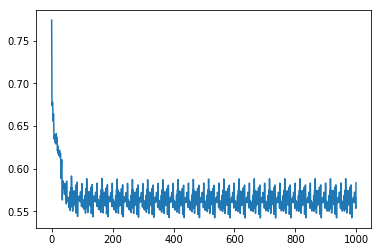

In [11]:
training_losses = train_network(num_epochs=num_training_epochs)
plt.plot(training_losses)
plt.show()